In [ ]:
!unzip dataset.zip

In [85]:
from IPython.display import Image
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, random_split
import os, sys
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import seaborn.objects as so

In [ ]:
# labels = pd.read_csv('dataset/test/test_annotation.txt', sep = ' ', names = ['filename', 'label'])
# labels.head()
# for i in range(len(labels)):
#     if labels.iloc[i,1] == 0:
#         os.replace(f"dataset/test/imgs/{labels.iloc[i,0]}", f"dataset/test/imgs/ne_proliv/{labels.iloc[i,0]}")
#     else:
#         os.replace(f"dataset/test/imgs/{labels.iloc[i,0]}", f"dataset/test/imgs/proliv/{labels.iloc[i,0]}")

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

train_transformed_dataset = torchvision.datasets.ImageFolder(root='./dataset/', transform=train_transform)
test_transformed_dataset = torchvision.datasets.ImageFolder(root='./dataset/', transform=test_transform)

In [5]:
train_transformed_dataset.class_to_idx

{'proliv': 0, 'test': 1, 'train': 2}

In [6]:
proliv_idx = 0
test_idx = train_transformed_dataset.targets.index(1)
train_idx = train_transformed_dataset.targets.index(2)

In [7]:
proliv_dataset = Subset(train_transformed_dataset, range(0, test_idx))
train_dataset = Subset(train_transformed_dataset, range(train_idx, len(train_transformed_dataset)))
train_dataset, validation_dataset = random_split(train_dataset, [9000, 1000])

In [8]:
proliv_loader = DataLoader(proliv_dataset, batch_size=100, shuffle = True)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [142]:
test_dataset = torchvision.datasets.ImageFolder(root='./dataset/test/imgs', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [152]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class BlockDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BlockDown, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = self.conv(x)
        return x

class BlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BlockUp, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, n_channels=3):
        super(Autoencoder, self).__init__()
        self.in_conv = DoubleConv(n_channels, 16)
        self.down1 = BlockDown(16, 32)
        self.down2 = BlockDown(32, 64)
        self.down3 = BlockDown(64, 128)
        self.down4 = BlockDown(128, 128)
        self.up1 = BlockUp(256, 64)
        self.up2 = BlockUp(128, 32)
        self.up3 = BlockUp(64, 16)
        self.up4 = BlockUp(32, 16)
        self.out_conv = nn.Conv2d(16, n_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x0 = self.in_conv(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.up4(x, x0)
        x = torch.tanh(self.out_conv(x))
        return x

In [153]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): BlockDown(
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

In [154]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

  0%|          | 0/3 [00:00<?, ?it/s]

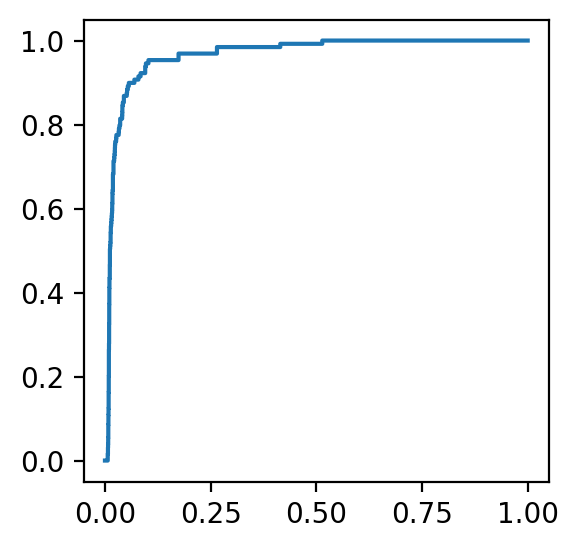

 33%|███▎      | 1/3 [00:30<01:00, 30.23s/it]

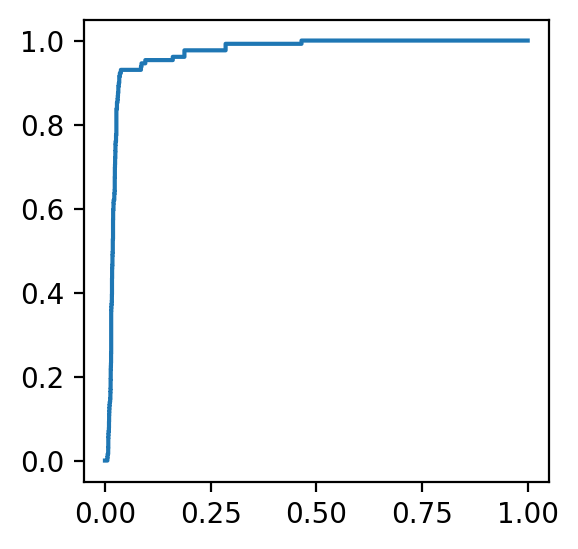

 67%|██████▋   | 2/3 [01:00<00:30, 30.20s/it]

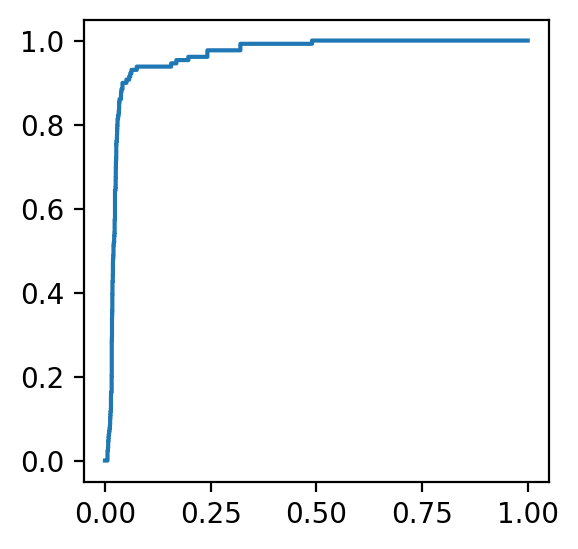

100%|██████████| 3/3 [01:29<00:00, 29.88s/it]


In [155]:
num_epochs = 8
train_loss = []
val_loss = []
for epoch in tqdm(range(num_epochs)):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())

    for data in validation_loader:
        with torch.no_grad():
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
    val_loss.append(loss.item())

    pred_mse = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_mse.append(criterion(outputs, images).item())
    fpr, tpr, thresholds = metrics.roc_curve(test_dataset.targets, pred_mse)
    plt.figure(figsize=(3,3))
    plt.plot(fpr,tpr,label="auc="+str(metrics.auc(fpr, tpr)))
    plt.show()

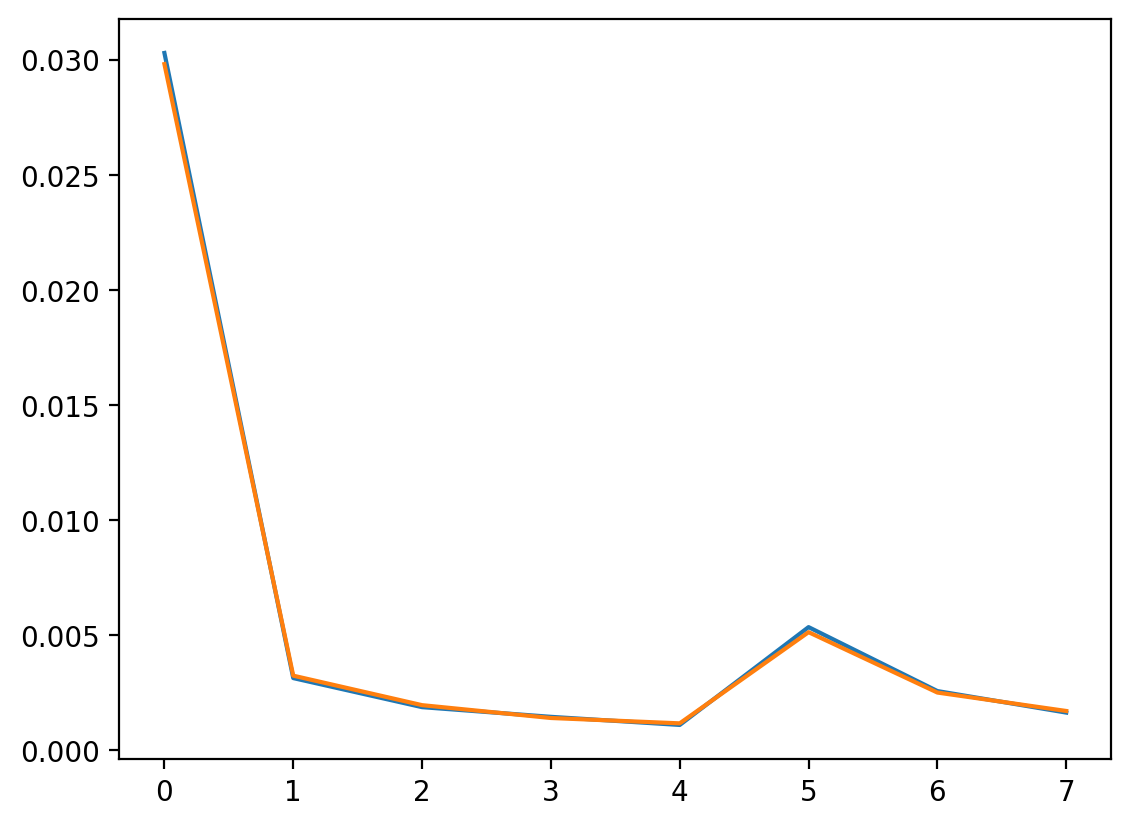

In [170]:
plt.plot(train_loss)
plt.plot(val_loss)

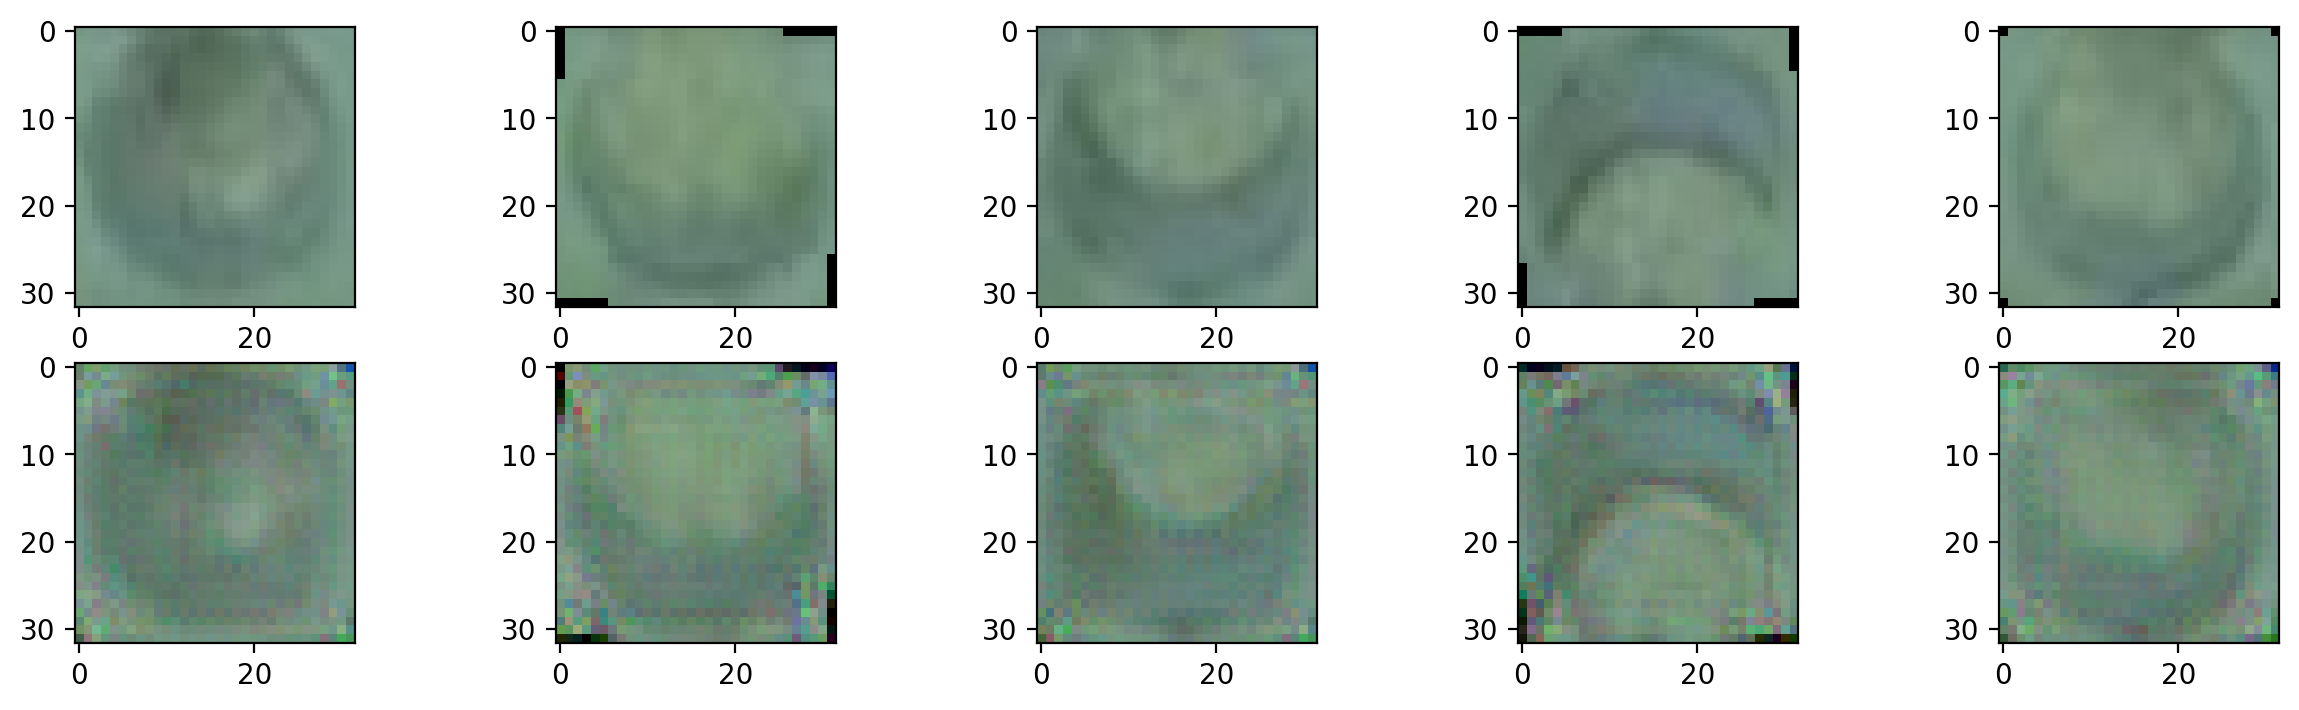

In [171]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        recon = model(data)
        break
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for i in range(5):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
plt.show()

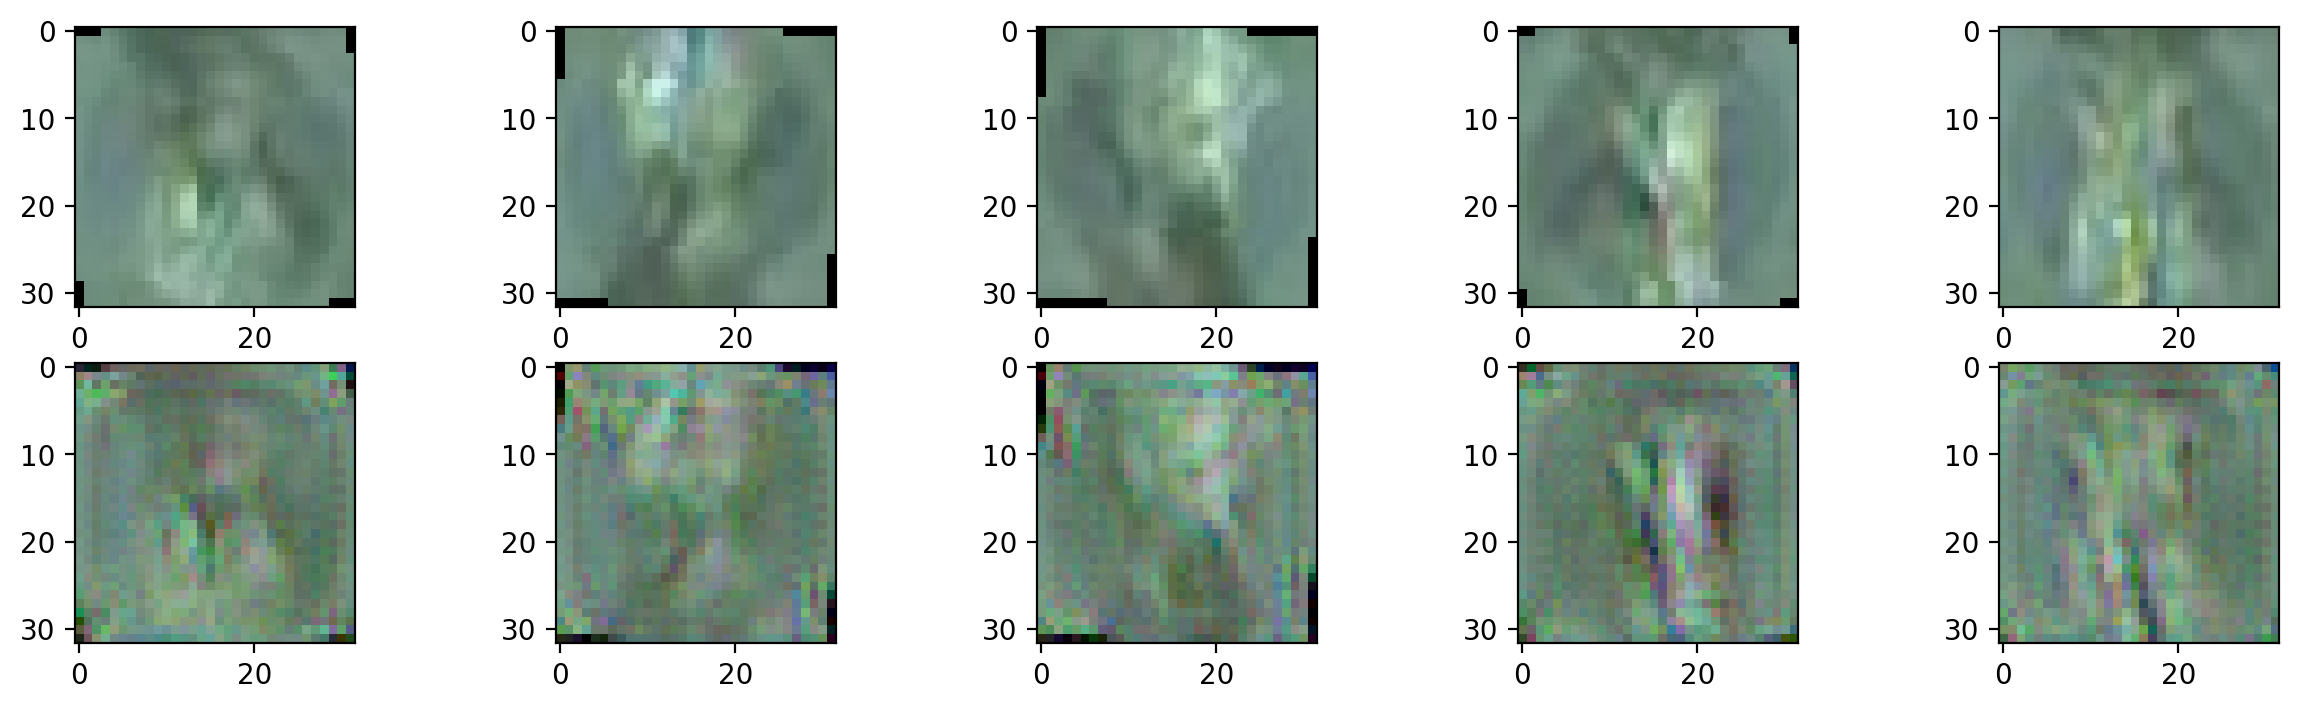

In [172]:
with torch.no_grad():
    for data, _ in proliv_loader:
        data = data.to(device)
        recon = model(data)
        break
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for i in range(5):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
plt.show()

In [174]:
train_loss = []

with torch.no_grad():
    for img, _ in DataLoader(train_dataset, batch_size=128, shuffle=False):
        img = img.to(device)
        outputs = model(img)
        loss = criterion(outputs, img)
        train_loss.append(float(loss.to('cpu')))
max(train_loss)

0.0018150521209463477

In [175]:
proliv_loss = []

with torch.no_grad():
    for img, _ in DataLoader(proliv_dataset, batch_size=1, shuffle=False):
        img = img.to(device)
        outputs = model(img)
        loss = criterion(outputs, img)
        proliv_loss.append(float(loss.to('cpu')))
min(proliv_loss)

0.002387779299169779

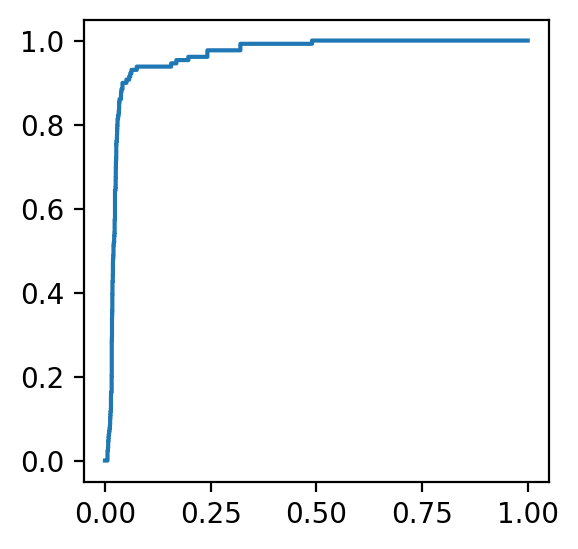

In [156]:
pred_mse = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        pred_mse.append(criterion(outputs, images).item())
fpr, tpr, thresholds = metrics.roc_curve(test_dataset.targets, pred_mse)
plt.figure(figsize=(3,3))
plt.plot(fpr,tpr,label="auc="+str(metrics.auc(fpr, tpr)))
plt.show()

In [169]:
optimal = np.argmax(tpr - fpr)
print(f"Threshold {thresholds[optimal]}")
print(f"TPR {tpr[optimal]}")
print(f"TNR {1 - fpr[optimal]}")

Threshold 0.0038445759564638138
TPR 0.9302325581395349
TNR 0.937244201909959
